In [1]:
import random
import networkx as nx
from IPython.core.display import SVG
import pyomo.environ as pyo
from pysat.solvers import Solver
from pysat.formula import CNF 
import py_svg_combinatorics as psc
from ipywidgets import widgets, HBox
from collections import Counter
from pprint import pprint
from random import randint
import numpy as np
from IPython.display import IFrame
import IPython
from copy import copy
import os
from pathlib import Path

def print_solution(m):
    for v in m.component_data_objects(pyo.Var):
        if v.value and v.value > 0:
            print(str(v), v.value)

nbname = ''
try:
    nbname = __vsc_ipynb_file__
except:
    if 'COCALC_JUPYTER_FILENAME' in os.environ:
        nbname = os.environ['COCALC_JUPYTER_FILENAME']    
title_ = Path(nbname).stem.replace('-', '_').title()    
IFrame(f'https://discopal.ispras.ru/index.php?title=Hardprob/{title_}&useskin=cleanmonobook', width=1280, height=300)


In [2]:
def visme(G, m=None):
    def norm_size(sz):
        return int(sz*100)

    pos = nx.get_node_attributes(G, "pos")
    if not pos:
        pos = nx.spring_layout(G)
        nx.set_node_attributes(G, pos, "pos")
    cut_edges = None 
    v_colors = ['blue'] * len(G.nodes())
    if m:
        p_colors_ = psc.get_hex_palette_for_n(m.k)
        cut_edges = [e for e in m.E if pyo.value(m.y[e])>0]
        for v in G.nodes():
            for p in m.P:
                if pyo.value(m.vp[v, p]) > 0:
                    v_colors[v] = p_colors_[p]

    nx.draw_networkx(
        G,
        pos,
        with_labels=True,
        edge_color="green",
        node_color=v_colors,
        node_size=300,
        style=':',
        width=0.4,
        font_size=6
    )

    if cut_edges:
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=cut_edges,
            edge_color="blue",
            node_size=200,
            width=0.7,
        )


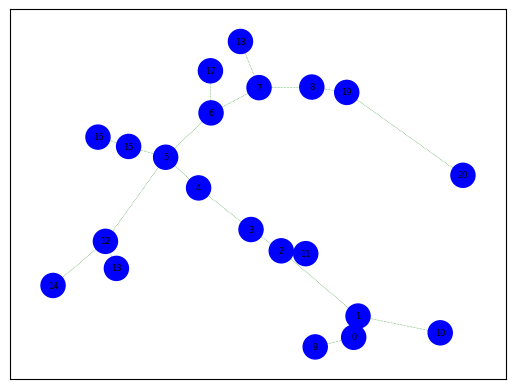

In [3]:
# G = nx.fast_gnp_random_graph(10, 0.5)
G = nx.random_lobster(12, 0.4, 0.4)
for (u, v) in G.edges():
    G.edges[u, v]['weight'] = np.random.rand()

visme(G)

In [4]:
def get_model(G, k):
    m = pyo.ConcreteModel()

    m.k = k
    m.P = list(range(k))
    m.E = list(G.edges())
    m.V = list(G.nodes())
    m.W = dict([(e[:2], e[2]['weight']) for e in G.edges(data=True)])
    m.m = len(m.E)
    m.n = len(m.V)
    bigM = 10000
    eps = 0.1

    # Номер разбиения
    m.vp = pyo.Var(m.V, m.P, domain=pyo.Binary)

    @m.Constraint(m.V)
    def каждая_вершина_в_ровно_одном_разбиении(m, v):
        return sum(m.vp[v, ...]) == 1

    @m.Constraint(m.P)
    def в_каждом_разбиении_есть_вершина(m, p):
        return sum(m.vp[..., p]) >= 1

    # соединяется ли ребро «uv» с партицией «p»
    m.uvp = pyo.Var(m.E, m.P, domain=pyo.Binary)

    @m.Constraint(m.V, m.E, m.P)
    def задаем_uvp(m, v_, u, v, p):
        if v == v_ or u == v_:
            return m.uvp[(u, v), p] >= m.vp[v_, p]
        return pyo.Constraint.Skip

    # 0-1 — на разрезе или нет.
    m.y = pyo.Var(m.E, domain=pyo.Binary)

    @m.Constraint(m.E)
    def ребро_на_разрезе_только_когда_вершины_в_двух_разбиениях(m, u, v):
        return m.y[(u,v)] == sum(m.uvp[(u, v), ...]) - 1

    m.cut_weight = pyo.Objective(expr = sum(m.W[e] * m.y[e] for e in m.E), sense=pyo.minimize)
    return m

m = get_model(G, 6)
#m.E, m.V

In [5]:
solver = pyo.SolverFactory('cbc')
solver.solve(m).write()
#print_solution(m)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 0.35442988
  Upper bound: 0.35442988
  Number of objectives: 1
  Number of constraints: 287
  Number of variables: 266
  Number of binary variables: 266
  Number of integer variables: 266
  Number of nonzeros: 20
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.47
  Wallclock time: 0.7
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Bra

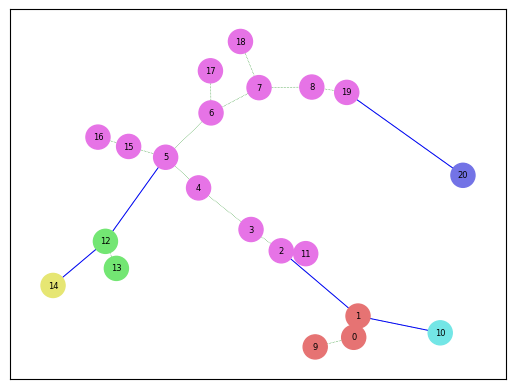

In [6]:
visme(G, m)